###### Content under Creative Commons Attribution license CC-BY 4.0, code under BSD 3-Clause License © 2021 Lorena A. Barba, Tingyu Wang

# Multiple linear regression

Welcome to Lesson 3 of our _Engineering Computations_ module on deep learning!

So far, we have only modeled the relationship between one input variable (also called _feature_) $x$ and one output variable $y$. More often than not, real-world model fitting involves making predictions using more than one feature. For example, you can build a model to predict the box-office gross revenue of Hollywood movies using trailer views, Wikipedia page views, critic ratings and time of release; or to predict the annual energy consumption of a building using its occupancy, structural information, weather data and so on.  In this lesson, we are going to extend the linear regression model to multiple input variables, i.e., we explore **multiple linear regression**.

## A real data set to work with

To have some data to work with, we grabbed the [auto miles per gallon (MPG) dataset](http://archive.ics.uci.edu/ml/datasets/Auto+MPG) from the UCI Machine Learning Repository, removed the missing data and formatted it as a csv file. Our goal is to predict the MPG (fuel efficiency) of a car using its technical specs.

Let's begin by importing the Python libraries we will use. The [Seaborn](https://seaborn.pydata.org) library for statistical data visualization will help us make beautiful plots. Seaborn is built on top of Matplotlib, and its plotting functions work seamlessly with dataframes or arrays.


In [1]:
import pandas
import seaborn
seaborn.set()

Let's read in the data and take a peek at it.
If you need to download the data, execute the following in a code cell:

```Python
from urllib.request import urlretrieve
URL = 'https://go.gwu.edu/engcomp6data3'
urlretrieve(URL, 'auto_mpg.csv')
```

In that case, the file will be downloaded in your working directory, so you should remove the directory path `../data/` from the file string below.

In [2]:
mpg_data = pandas.read_csv('../data/auto_mpg.csv')
mpg_data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


From the first few rows you get a sense for what's in this data set. Use [`pandas.DataFrame.info()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.info.html) to see a quick summary of the data.

In [3]:
mpg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    float64
 5   acceleration  392 non-null    float64
 6   model year    392 non-null    int64  
 7   origin        392 non-null    int64  
 8   car name      392 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 27.7+ KB


We have 392 entries and each is associated with a specific car model. The data consists of altogether 9 columns. Except for `car name`, values in all other columns are numeric. Despite being numeric, the `origin` column, indicating the country of origin, corresponds to categorical data.  We expect that the name of a car won't affect its MPG (country of origin might); for simplicity, we exclude `car name` and `origin` as features to predict the MPG.

Now, let's define the feature columns: `x_cols` and the output column: `y_cols`.

In [4]:
y_col = 'mpg'
x_cols = mpg_data.columns.drop(['car name', 'origin', 'mpg'])  # also drop mpg column

print(x_cols)

Index(['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration',
       'model year'],
      dtype='object')


We end up keeping 6 features, or independent variables (all technical specs of a car), that we expect to be correlated with MPG, the dependent variable.

## Data exploration

Before choosing a model to fit our data, exploring the data is equally important but often ignored. The best way to start is to visualize the relationship between input and output variables.

We have used scatter plots before to visualize the relationship between just two variables. 
Since now we are dealing with 6 independent variables, we want to make such a plot for each one; luckily, `seaborn` provides the handy function [`seaborn.pairplot()`](https://seaborn.pydata.org/generated/seaborn.pairplot.html) to plot these 6 figures in one go. Check it out! You can double-click the figure to expand the view.

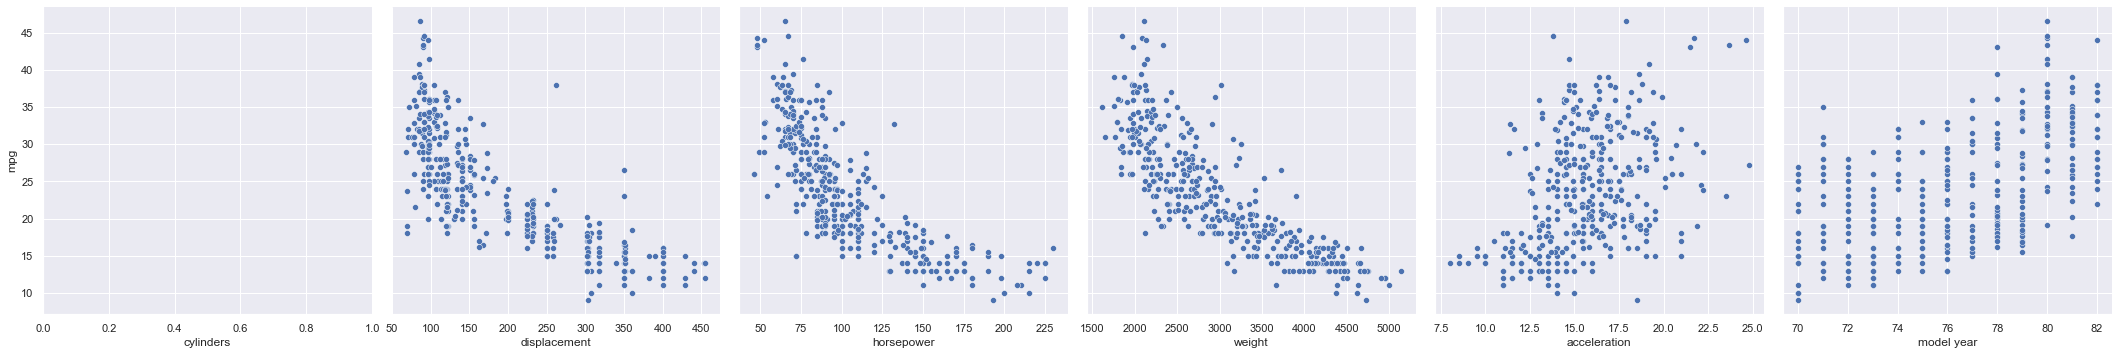

In [5]:
seaborn.pairplot(data=mpg_data, height=5, aspect=1,
             x_vars=x_cols,
             y_vars=y_col);

Inspect these plots and make some mental notes of what you see. 
The features: `model_year`, `acceleration` show a positive correlation with `mpg`, while the rest show a negative correlation with `mpg`.
It looks like a linear model might represent well the relationship of all six features with our output variable.

## Linear model in matrix form

If every feature $x_i$ is correlated with $y$ individually, it is natural to think that combining them linearly would be a good fit for $y$. Formally, the multiple linear regression model for $d$ input variables can be written as:

$$
\hat{y} = w_0 + w_1 x_1 + w_2 x_2 + \ldots + w_d x_d, 
$$

where the "hat" on $y$ denotes a predicted value.
Notice that we have $d+1$ weights for $d$ features, and $w_0$ is the intercept term. By letting $x_0 = 1$ for all data points, we can simplify the notation as:

$$
\hat{y} = \sum_{i=0}^{d} w_d x_d = \mathbf{w}^T \mathbf{x}, 
$$

where $\mathbf{w} = (w_0, w_1, \ldots, w_d)^T$ is the vector of weights, and $\mathbf{x} = (x_0, x_1, \ldots, x_d)^T$ the vector of input variables.

Since we've used subscripts to denote features, let's index our dataset entries with superscripts. For example, $x_1^{(i)}$ represents the `cylinders` (the first feature) value of the $i$-th car model.

Suppose our dataset has $N$ entries; writing out our model for each entry, we have:

\begin{align*}
\hat{y}^{(1)} & = w_0 x_0^{(1)} + w_1 x_1^{(1)} + w_2 x_2^{(1)} + \ldots + w_d x_d^{(1)} \\
\hat{y}^{(2)} & = w_0 x_0^{(2)} + w_1 x_1^{(2)} + w_2 x_2^{(2)} + \ldots + w_d x_d^{(2)} \\
&\vdots \\
\hat{y}^{(N)} & = w_0 x_0^{(N)} + w_1 x_1^{(N)} + w_2 x_2^{(N)} + \ldots + w_d x_d^{(N)}  \\
\end{align*}

Finally, we arrive at the matrix form of the multiple linear regression model:

$$
\hat{\mathbf{y}} = X\mathbf{w}
$$

The $X$ is the matrix of our input variables. To form $X$, we need to pad a column of $1$s to the left of our original data as the dummy feature corresponding to the intercept $w_0$. We use $\hat{\mathbf{y}}$ to represent the vector of the predicted output variables, and $\mathbf{y}$ to represent the vector of the observed (true) output variables.

Before coding our model, let's import from the automatic differentiation library `autograd` both its NumPy wrapper and the `grad()` function, as we learned to do in Lesson 2.

In [6]:
from autograd import numpy
from autograd import grad

Let's prepare the input matrix $X$ and the vector $\mathbf{y}$ directly from our dataset.
In the code below, we grab the columns `x_cols` from the dataframe `mpg_data` and extract the values into a NumPy array `X` (a matrix). 
The NumPy function [`hstack()`](https://numpy.org/doc/stable/reference/generated/numpy.hstack.html) is used to stack arrays horizontally (by columns). 
We also slice the single column `y_col` of the dataframe, and extract the values into a NumPy array `y`. 
Check out the array shapes.

In [7]:
X = mpg_data[x_cols].values
X = numpy.hstack((numpy.ones((X.shape[0], 1)), X))  # pad 1s to the left of input matrix
y = mpg_data[y_col].values

print(f"{X.shape = }, {y.shape = }")

X.shape = (392, 7), y.shape = (392,)


Like in the single-variable linear regression model of Lesson 1, we use the the **mean squared error** loss function, over all the data points: 

$$L(\mathbf{y}, \hat{\mathbf{y}}) = \frac{1}{N} \sum_{i=1}^{N}(y^{(i)} - \hat{y}^{(i)})^2$$

We're ready to define Python functions for the multiple linear regresssion model and the loss function.

In [8]:
def linear_regression(params, X):
    '''
    The linear regression model in matrix form.
    Arguments:
      params: 1D array of weights for the linear model
      X     : 2D array of input values
    Returns:
      1D array of predicted values
    '''
    return numpy.dot(X, params)

def mse_loss(params, model, X, y):
    '''
    The mean squared error loss function.
    Arguments:
      params: 1D array of weights for the linear model
      model : function for the linear regression model
      X     : 2D array of input values
      y     : 1D array of predicted values
    Returns:
      float, mean squared error
    '''
    y_pred = model(params, X)
    return numpy.mean( numpy.sum((y-y_pred)**2) )

## Find the weights by gradient descent

Following Lesson 2, we know that `autograd.grad()` will give us the function to compute the derivatives required in gradient descent.

In [9]:
gradient = grad(mse_loss)

Let's test the function with a random initial guess:

In [10]:
gradient(numpy.random.rand(X.shape[1]), linear_regression, X, y)

array([1.51937270e+06, 9.00915292e+06, 3.39809844e+08, 1.73959611e+08,
       4.90357230e+09, 2.30619635e+07, 1.14907082e+08])

Oops, it does not look nice. With the random weights, the gradient values are huge. Let us try with a few iterations in gradient descent.

In [11]:
max_iter = 30
alpha = 0.001
params = numpy.zeros(X.shape[1])

for i in range(max_iter):
    descent = gradient(params, linear_regression, X, y)
    params = params - descent * alpha
    loss = mse_loss(params, linear_regression, X, y)
    if i%5 == 0:
        print(f"iteration {i:3}, {loss = }")

iteration   0, loss = 9.668521029386562e+18
iteration   5, loss = 5.933187473385039e+87
iteration  10, loss = 3.6409616934209154e+156
iteration  15, loss = 2.234313699411096e+225
iteration  20, loss = 1.37110964841974e+294
iteration  25, loss = inf


<ipython-input-8-bc833f0063da>:24: RuntimeWarning: overflow encountered in square
  return np.mean( np.sum((y-y_pred)**2) )
/opt/anaconda3/lib/python3.8/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in power
  return f_raw(*args, **kwargs)


Yikes! This is definitely not good. What could be going on here?

### Feature scaling

As you saw above, the gradient descent algorithm is blowing up. This is because of the big numbers in certain columns, for instance, look at the `weight` column. In addition, having features with varying magnitudes will also lead to slow convergence in the gradient descent iterations. Therefore, it is critical to make sure that all features are on a similar scale. This step is also called **feature scaling** or **data normalization**.

Let's check the range of our features.

In [12]:
mpg_data[x_cols].describe().loc[['max', 'min']]

,cylinders,displacement,horsepower,weight,acceleration,model year
max,8.0,455.0,230.0,5140.0,24.8,82.0
min,3.0,68.0,46.0,1613.0,8.0,70.0


One commonly used feature scaling technique is **min-max scaling**, which scales the range of each feature to the interval $[0,1]$. If $x$ is the original value of a feature, its scaled (normalized) value $x^{\prime}$ is given as:

$$
x^{\prime}=\frac{x-\min (x)}{\max (x)-\min (x)}
$$

We will now introduce a new Python library: [**scikit-learn**](https://scikit-learn.org/stable/). 
It is the standard tool for machine-learning tasks in Python. 
So far, we've made some headway with the tools you know from previous _Engineering Computations_ modules, including NumPy, SymPy, and pandas. 
But we reached a point where it's so much easier to start using `scikit-learn`!

Here, we'll use the function [`sklearn.preprocessing.MinMaxScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) to rescale our $X$.

And check the range of each column of $X$ again.

In [13]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(mpg_data[x_cols])
X_scaled = numpy.hstack((numpy.ones((X_scaled.shape[0], 1)), X_scaled))    # add the column for intercept

pandas.DataFrame(X_scaled).describe().loc[['max', 'min']]

,0,1,2,3,4,5,6
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Notice that column **0** corresponds to the dummy data for the intercept. All values in that column are 1.

Finally, we are ready to run gradient descent to find the optimal parameters for our multiple linear regression model.

In [14]:
max_iter = 1000
alpha = 0.001
params = numpy.zeros(X.shape[1])

for i in range(max_iter):
    descent = gradient(params, linear_regression, X_scaled, y)
    params = params - descent * alpha
    loss = mse_loss(params, linear_regression, X_scaled, y)
    if i%100 == 0:
        print(f"iteration {i:3}, {loss = }")

iteration   0, loss = 116081.11124253296
iteration 100, loss = 5035.737208606848
iteration 200, loss = 4694.653830594688
iteration 300, loss = 4613.631473760375
iteration 400, loss = 4583.327630964672
iteration 500, loss = 4568.155268087917
iteration 600, loss = 4559.268593877387
iteration 700, loss = 4553.692765631067
iteration 800, loss = 4550.099857254159
iteration 900, loss = 4547.761957132872


Let's print out the trained weights. Recall that the first element is the intercept, and the rest correspond to the 6 features respectively.

In [15]:
params

array([ 27.56342896,  -1.24000064,   1.70706502,  -0.2853682 ,
       -23.08358717,   1.06664226,   8.99271696])

Now, we can make predictions with our model, and this step reduces to a matrix-vector multiplication.

In [16]:
y_pred_gd = X_scaled @ params

### How accurate is the model?

One thing that we haven't discussed till now is how to quantify the accuracy of a model. For regression problems, two basic metrics are the mean absolute error (MAE) and the root-mean-squared error (RMSE). The latter is just the square root of the MSE loss function that we used above.

$$
\mathrm{MAE}(\mathbf{y}, \hat{\mathbf{y}})=\frac{1}{N} \sum_{i=1}^{N}\left|y^{(i)}-\hat{y}^{(i)}\right|
$$

$$
\mathrm{RMSE}(\mathbf{y}, \hat{\mathbf{y}})=\sqrt{\frac{1}{N} \sum_{i=1}^{N}\left(y^{(i)}-\hat{y}^{(i)}\right)^{2}}
$$

Most common metrics are available in **scikit-learn**. Let's compute both errors using the corresponding functions in the [`sklearn.metrics`](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) module.

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y, y_pred_gd)
rmse = mean_squared_error(y, y_pred_gd, squared=False)
print(f"gradient descent")
print(f"{mae  = }")
print(f"{rmse = }")

gradient descent
mae  = 2.613991601156044
rmse = 3.4055205674118403


## Linear regression with scikit-learn

We want to mention that the [`LinearRegression()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html?highlight=linearregression#sklearn-linear-model-linearregression) function in **scikit-learn** offers the same capability we've coded from scratch above. Now with a better understanding of the model, you should feel more comfortable to use these black-boxes. 

Check out how the code looks like using this tool: just four lines of code do all the work!

In [18]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=False).fit(X, y)
y_pred_sklearn = model.predict(X)

mae = mean_absolute_error(y, y_pred_sklearn)
rmse = mean_squared_error(y, y_pred_sklearn, squared=False)
print(f"scikit-learn linear regression")
print(f"{mae  = }")
print(f"{rmse = }")

scikit-learn linear regression
mae  = 2.6182640467289517
rmse = 3.4044340177796406


## Linear regression with pseudo-inverse

We want to conclude this notebook with a callback to the final lesson in the _Engineering Computations_ module on Linear Algebra, [Module 4](https://openedx.seas.gwu.edu/courses/course-v1:GW+EngComp4+2019/about). Recall that we can use singular value decomposition (SVD) to obtain the pseudo-inverse of a matrix and that the pseudo-inverse offers a least-squares solution of the corresponding linear system. Given $X$ and $\mathbf{y}$, finding the linear regression weights $\mathbf{w}$ that minimize the MSE loss function is exactly a least-squares problem.

Performing SVDs on large datasets might not be ideal, but let's try on this one.

In [19]:
from scipy.linalg import pinv

params = pinv(X) @ y
y_pred_svd = X @ params

mae = mean_absolute_error(y, y_pred_svd)
rmse = mean_squared_error(y, y_pred_svd, squared=False)
print(f"linear regression using pseudo inverse")
print(f"{mae  = }")
print(f"{rmse = }")

linear regression using pseudo inverse
mae  = 2.618264046728941
rmse = 3.404434017779641


If you look carefully enough, you will notice that the error from using pseudo-inverse is almost identical to the error from using the `sklearn.linear_model.LinearRegression()` function. In fact, that is exactly how `LinearRegression()` is implemented in **scikit-learn**, since a closed-form solution is available. However, for more complicated models, we have to use gradient descent. 

And this concludes Lesson 3 of our _Engineering Computations_ module on deep learning. 
We take a step-by-step approach to help you build understanding and demistify this booming subject that every scientist and engineer should know about!

## What we've learned

- The [Seaborn](https://seaborn.pydata.org/) library for statistical visualization has handy tools to make beautiful plots!
- A linear regression model with many input variables (a.k.a. features) is written neatly in matrix form as $\hat{\mathbf{y}} = X\mathbf{w}$, where $X$ is the matrix of features and $w$ is the vector of weights.
- Gradient descent can blow up with features that have disparate scales. Feature scaling (or normallization) solves this problem.
- [**scikit-learn**](https://scikit-learn.org/stable/) is the standard tool for machine-learning tasks in Python.
- The [`LinearRegression()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html?highlight=linearregression#sklearn-linear-model-linearregression) function in **scikit-learn** fits a linear model with multiple features.
- We can also do multiple linear regression using the matrix pseudo-inverse, obtained with SVD.

In [20]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = '../style/custom.css'
HTML(open(css_file, "r").read())